In [1]:
import torch
print(torch.__version__)  # Should output 2.6.0
print(torch.cuda.is_available())  # Should return True if CUDA is properly configured


2.6.0+cu124
True


In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset

class PokemonDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))  # Ensure consistent class order
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [3]:
from PIL import Image

def resize(image, size):
    return image.resize(size, Image.Resampling.LANCZOS)  # Updated to use Resampling.LANCZOS



In [4]:
import numpy as np
import torch

def to_tensor(image):
    # Convert PIL Image to NumPy array and normalize pixel values to [0, 1]
    array = np.array(image) / 255.0
    # Rearrange dimensions to [C, H, W] for PyTorch (channels-first)
    tensor = torch.tensor(array.transpose((2, 0, 1)), dtype=torch.float32)
    return tensor


In [5]:
def normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.sub_(m).div_(s)  # Normalize each channel
    return tensor


In [6]:
def custom_transform(image):
    image = resize(image, (128, 128))  # Resize
    tensor = to_tensor(image)         # Convert to tensor
    tensor = normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    return tensor


In [7]:
class PokemonDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [8]:
train_dataset = PokemonDataset(root_dir='data/train', transform=custom_transform)


In [10]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse the normalization
    return tensor


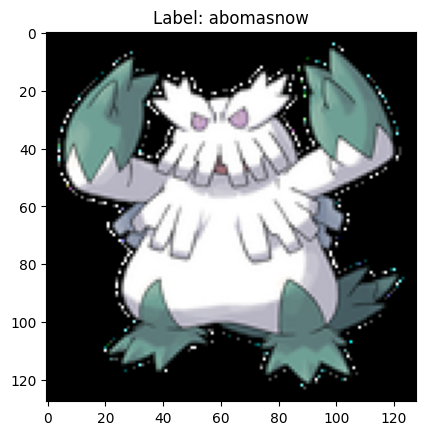

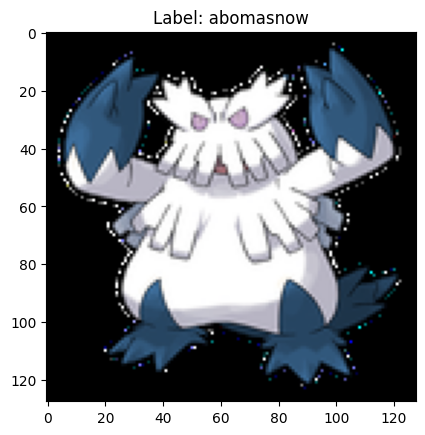

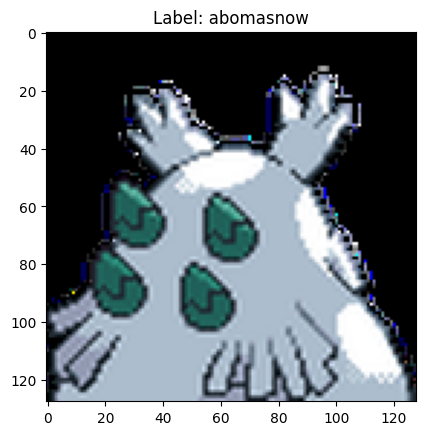

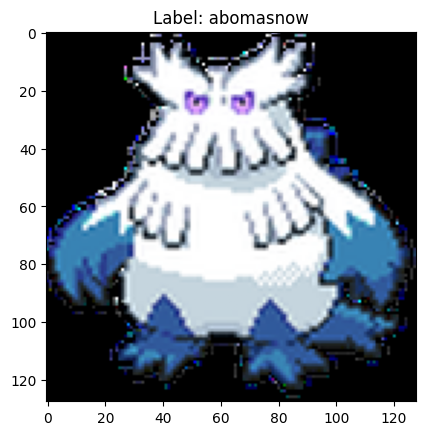

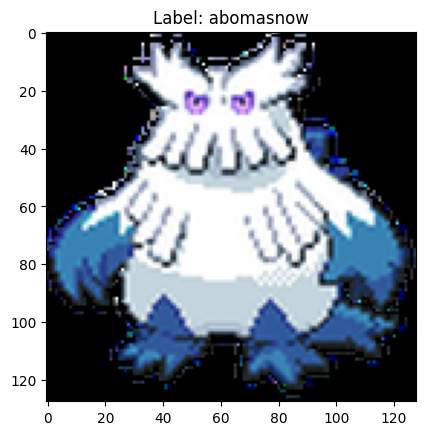

In [11]:
import matplotlib.pyplot as plt

# Mean and std used for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Visualize a few samples
for i in range(5):
    image, label = train_dataset[i]

    # Denormalize the image
    image = denormalize(image.clone(), mean, std)
    image = image.permute(1, 2, 0).numpy()  # Convert to HWC format

    # Clip the values to [0, 1] range for proper visualization
    image = image.clip(0, 1)

    plt.imshow(image)
    plt.title(f"Label: {train_dataset.classes[label]}")
    plt.show()



In [12]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [19]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


AttributeError: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)

In [18]:
from torch.utils.data import DataLoader

train_dataset = PokemonDataset(root_dir='dataset/train', transform=transform)
test_dataset = PokemonDataset(root_dir='dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


NameError: name 'transform' is not defined

In [14]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Adapt to 128x128 input
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=len(train_dataset.classes)).cuda()



In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [16]:
for epoch in range(10):  # Number of epochs
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


Epoch 1, Loss: 6.30582108118483
Epoch 2, Loss: 3.45497398638944
Epoch 3, Loss: 1.3291824287777647
Epoch 4, Loss: 0.513100118914602
Epoch 5, Loss: 0.24862202155099047
Epoch 6, Loss: 0.17111898196821274
Epoch 7, Loss: 0.16167179706281432
Epoch 8, Loss: 0.1211186545815202
Epoch 9, Loss: 0.10898858904646316
Epoch 10, Loss: 0.0862957715490813


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")
